In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#importo il dataset
path = "/kaggle/input/cifar10-hw3/cifar_hw3"

X_train = np.load(f"{path}/x_train.npy")
X_val = np.load(f"{path}/x_val.npy")
X_test = np.load(f"{path}/x_test.npy")

Y_train = np.load(f"{path}/y_train.npy")
Y_val = np.load(f"{path}/y_val.npy")
Y_test = np.load(f"{path}/y_test.npy")


In [2]:
def trova_patch_uniforme(image, patch_size=5):
    #Trovo la patch più uniforme in una immagine RGB
    h, w, c = image.shape
    min_std = float('inf')
    coordinate = (0, 0)

    for i in range(h - patch_size + 1):
        for j in range(w - patch_size + 1):
            patch = image[i:i+patch_size, j:j+patch_size, :]
            patch_std = np.std(patch, axis=(0, 1))
            mean_std = np.mean(patch_std)

            if mean_std < min_std:
                min_std = mean_std
                coordinate = (i, j)

    return coordinate, min_std

def colore_medio_bordo(image, i, j, patch_size=5):
    #Calcolo il colore medio dei bordi intorno alla patch
    h, w, c = image.shape
    top = max(i - 1, 0)
    bottom = min(i + patch_size + 1, h)
    left = max(j - 1, 0)
    right = min(j + patch_size + 1, w)

    border_pixels = []

    if top < i:
        border_pixels.append(image[top, left:right, :])
    if bottom > i + patch_size:
        border_pixels.append(image[bottom - 1, left:right, :])
    if left < j:
        border_pixels.append(image[top:bottom, left, :])
    if right > j + patch_size:
        border_pixels.append(image[top:bottom, right - 1, :])

    if border_pixels:
        border_pixels = np.concatenate(border_pixels, axis=0)
        return np.mean(border_pixels, axis=0)
    else:
        return np.mean(image.reshape(-1, c), axis=0) 

def rimuovi_patch(image, patch_size=5, soglia_std=10):
    #Rimuovo la patch trovata in precedenza
    image_copy = image.copy()
    (i, j), patch_std = trova_patch_uniforme(image_copy, patch_size)
    if patch_std < soglia_std:
        colore_sostitutivo = colore_medio_bordo(image_copy, i, j, patch_size)
        image_copy[i:i+patch_size, j:j+patch_size, :] = colore_sostitutivo
    return image_copy



def pulisci_dataset(images, patch_size, soglia_std):
    #Applico la rimozione patch a tutte le immagini
    return np.array([rimuovi_patch(img.copy(), patch_size, soglia_std) for img in images])


In [4]:
# Pulisco il dataset senza modificare gli originali
x_train_cleaned = pulisci_dataset(X_train, patch_size=5, soglia_std=10)


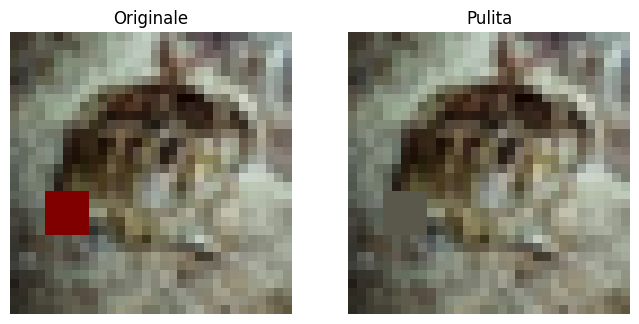

In [11]:
# Prendo la prima immagine originale e quella ripulita
originale = X_train[0]
pulita = x_train_cleaned[0]

plt.figure(figsize=(8,8))

# Immagine originale a sinistra
plt.subplot(1, 2, 1)
plt.imshow(originale)
plt.title("Originale")
plt.axis('off')

# Immagine ripulita a destra
plt.subplot(1, 2, 2)
plt.imshow(pulita)
plt.title("Pulita")
plt.axis('off')

plt.show()

In [6]:
#appiattisco (non utilizzo il validation set perche GridSearch effettua una cross-validation interna)
x_train_flat = x_train_cleaned.reshape(x_train_cleaned.shape[0], -1)
x_test_flat = X_test.reshape(X_test.shape[0], -1)

#standardizzo
scaler = StandardScaler()
x_train_flat = scaler.fit_transform(x_train_flat)
x_test_flat = scaler.transform(x_test_flat)

In [13]:
#definisco MLP
mlp = MLPClassifier(
    early_stopping=True,        
    n_iter_no_change=5,
    max_iter=250,
    validation_fraction=0.1,    
    random_state=42
)

#definisco griglia parametri
param_grid = {
    'hidden_layer_sizes': [(128, 64), (256, 128)],
    'alpha': [0.0001, 0.001],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01],
}

grid_search = GridSearchCV(mlp, param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(x_train_flat, Y_train.ravel())

#Stampo migliori parametri e accuracy
print("Migliori parametri:", grid_search.best_params_)
print("Accuracy :", grid_search.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Migliori parametri: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (256, 128), 'learning_rate_init': 0.001, 'solver': 'adam'}
Accuracy : 0.48646001398944777
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, solver=adam; total time= 1.6min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, solver=adam; total time= 2.2min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(256, 128), learning_rate_init=0.001, solver=adam; total time= 3.2min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, solver=adam; total time= 1.5min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, solver=adam; total time= 1.5min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, solver=adam; total time= 2.9min
[CV

Accuracy sul test set: 0.5052


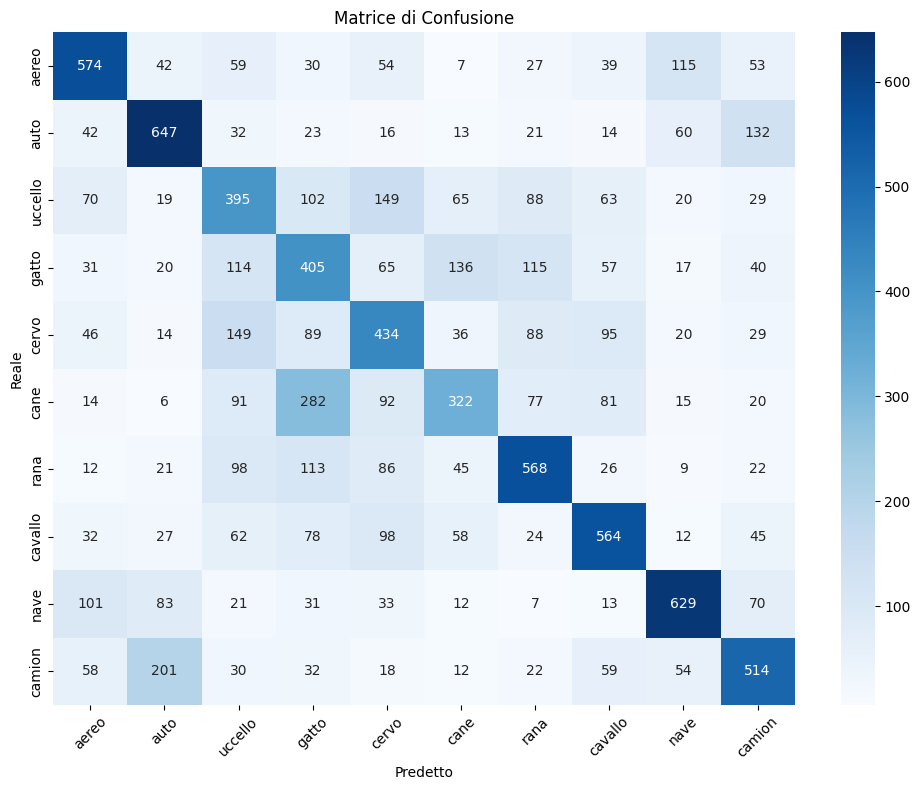


Classification Report:
              precision    recall  f1-score   support

       aereo       0.59      0.57      0.58      1000
        auto       0.60      0.65      0.62      1000
     uccello       0.38      0.40      0.39      1000
       gatto       0.34      0.41      0.37      1000
       cervo       0.42      0.43      0.42      1000
        cane       0.46      0.32      0.38      1000
        rana       0.55      0.57      0.56      1000
     cavallo       0.56      0.56      0.56      1000
        nave       0.66      0.63      0.64      1000
      camion       0.54      0.51      0.53      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.50     10000
weighted avg       0.51      0.51      0.50     10000



In [29]:
#Predizioni sul test set
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(x_test_flat)

#Accuracy sul test set
acc_test = accuracy_score(Y_test, y_test_pred)
print("Accuracy sul test set:", acc_test)

#Nomi delle classi CIFAR-10
class_names = ['aereo', 'auto', 'uccello', 'gatto', 'cervo', 'cane', 'rana', 'cavallo', 'nave', 'camion']

#Matrice di confusione
cm = confusion_matrix(Y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.title('Matrice di Confusione')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("matrice_confusione.png", dpi=300, bbox_inches='tight')
plt.show()

#Classification report
print("\nClassification Report:")
print(classification_report(Y_test, y_test_pred, target_names=class_names))
